In [1]:
#--- 
import pandas as pd
import numpy as np
#---
import re
from unidecode import unidecode
#---
import datetime

#---
import matplotlib.pyplot as plt
import seaborn as sns
#--- Scraping
import requests
from bs4 import BeautifulSoup

#---
import os
import requests
import gzip
import shutil
from tqdm import tqdm

from datetime import timedelta, date
import math
import requests
from bs4 import BeautifulSoup
from pathlib import Path

## Importación de Datos

In [2]:
homicidios = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'HECHOS', engine='openpyxl')
victima_h = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'VICTIMAS',  engine='openpyxl')
comunas_h = pd.read_excel('../datasets/raw/comunas.xlsx' , sheet_name = 'comunas',  engine='openpyxl')
#lesiones = pd.read_excel('../datasets/raw/lesiones.xlsx' , sheet_name = 'HECHOS',  engine='openpyxl')
#victima_l = pd.read_excel('../datasets/raw/lesiones.xlsx' , sheet_name = 'VICTIMAS',  engine='openpyxl')
censo_r = pd.read_csv('../datasets/raw/informacion-censal-por-radio-2010.csv')
# Revsisón de Modelo de datos
homicidios.name = 'homicidios'
victima_h.name = 'victima_h'
comunas_h.name = 'comunas_h'
#lesiones.name = 'lesiones'
#victima_l.name = 'victima_l'
censo_r.name = 'censo_r'

In [3]:
pd.set_option('display.max_columns', None)
dataframes = [homicidios, victima_h, comunas_h, censo_r]

In [4]:
for df in dataframes:
    print(f"Dataframe {df.name}:\nRegistros {df.shape[0]} y Columnas {df.shape[1]}\n")

Dataframe homicidios:
Registros 696 y Columnas 21

Dataframe victima_h:
Registros 717 y Columnas 10

Dataframe comunas_h:
Registros 15 y Columnas 6

Dataframe censo_r:
Registros 3554 y Columnas 15



## PreProcesamiento de Datos

In [5]:
# Función para limpiar y formatear los nombres de las columnas
def limpiar_nombre(nombre):
    # Eliminar caracteres especiales y espacios
    nombre = re.sub(r'\W+', '_', nombre)
    # Eliminar acentos
    nombre = unidecode(nombre)
    # Convertir a minúsculas
    nombre = nombre.lower()
    return nombre

def limpiar_nombres_columnas(df):
    df.columns = [limpiar_nombre(col) for col in df.columns]

# Aplicar la función limpiar_nombres_columnas a cada DataFrame
for df in dataframes:
    limpiar_nombres_columnas(df)

# Imprimir los nombres de las columnas limpias para cada DataFrame
for df in dataframes:
    print(f"Columnas de {df.name}:")
    print(df.columns)
    print()

Columnas de homicidios:
Index(['id', 'n_victimas', 'fecha', 'aaaa', 'mm', 'dd', 'hora', 'hh',
       'lugar_del_hecho', 'tipo_de_calle', 'calle', 'altura', 'cruce',
       'direccion_normalizada', 'comuna', 'xy_caba_', 'pos_x', 'pos_y',
       'participantes', 'victima', 'acusado'],
      dtype='object')

Columnas de victima_h:
Index(['id_hecho', 'fecha', 'aaaa', 'mm', 'dd', 'rol', 'victima', 'sexo',
       'edad', 'fecha_fallecimiento'],
      dtype='object')

Columnas de comunas_h:
Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

Columnas de censo_r:
Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi'],
      dtype='object')



In [6]:
def reemplazar_nulos_y_raros(dataframes, valores_raros):
    dataframes_limpios = []

    for df in dataframes:
        # Reemplazar los valores raros con NaN
        df = df.replace(valores_raros, pd.NaT)

        # Reemplazar los valores nulos con NaN
        df = df.replace('', pd.NaT)

        dataframes_limpios.append(df)

    return dataframes_limpios

dataframes = [homicidios, victima_h, comunas_h, censo_r]
# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '']
# Ejemplo de uso
# Supongamos que tienes una lista de DataFrames llamada 'dataframes' y 'valores_raros' es la lista de valores raros
dataframes_limpios = reemplazar_nulos_y_raros(dataframes, valores_raros)

# Puedes asignar cada DataFrame tratado a una variable separada
homicidios_l, victima_h_l, comunas_h_l, censo_r_l = dataframes_limpios.copy()


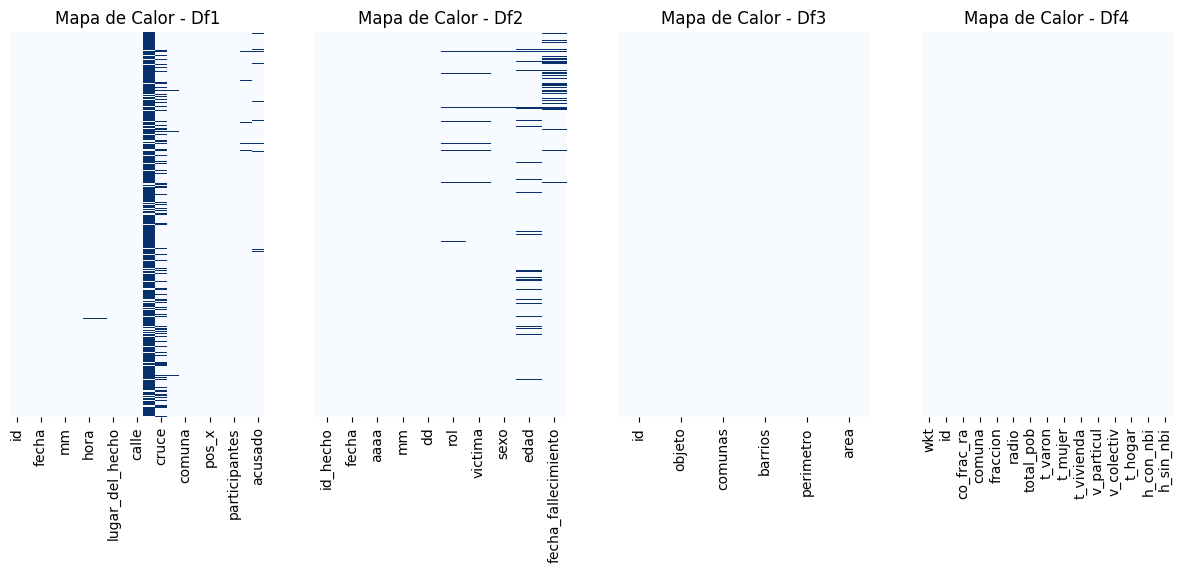

In [7]:
n_dataframes = len(dataframes_limpios)

# Configurar la disposición de los subgráficos
fig, axs = plt.subplots(1, n_dataframes, figsize=(15, 5))  # Ajusta el tamaño según tus necesidades

# Iterar sobre los índices de los DataFrames y dibujar el mapa de calor en cada subgráfico
for i in range(n_dataframes):
    sns.heatmap(dataframes_limpios[i].isna(), yticklabels=False, cbar=False, cmap="Blues", ax=axs[i])
    axs[i].set_title(f'Mapa de Calor - Df{i+1}')  # Utiliza el índice para el título

plt.show()

**Se asume la politica de eliminar, según reporte EDA:**
-  Campos gravedad de Df victima_l con 98% Faltantes, 
-  Campos gravedad de Df lesiones con 97% Faltantes y
-  Campos altura de Df homicidios con 81% Faltantes.

In [8]:
def procesar_dataframe(df):
    # Convertir la columna de fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Crear nuevas columnas para año, mes y día
    df['anio'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia'] = df['fecha'].dt.day

    # Llenar los valores nulos en 'hora' con '00:00:00'
    df['hora'] = df['hora'].fillna('00:00:00')


    # Convertir 'hora' a formato datetime
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')

    # Crear una nueva columna para fecha y hora combinadas
    df['fecha_hora'] = pd.to_datetime(dict(
        year=df['anio'],
        month=df['mes'],
        day=df['dia'],
        hour=df['hora'].dt.hour,
        minute=df['hora'].dt.minute
    ))

    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd', 'hh','hora','altura']
    df = df.drop(columns=columns_to_drop)

    # Crear columnas formateadas para fecha y hora
    df['fecha_formato'] = df['fecha_hora'].dt.strftime('%Y-%m-%d')
    df['hora_formato'] = df['fecha_hora'].dt.strftime('%H:%M')
    df['hora_i'] = df['fecha_hora'].dt.strftime('%H')
    df['hora_i'] = df['hora_i'].astype('int')

    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'df'
homicidios_l = procesar_dataframe(homicidios_l.copy())


In [9]:
def procesar_homicidios_l(df):
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
homicidios_l = procesar_homicidios_l(homicidios_l.copy())

In [10]:
def procesar_homicidios_l(df):
    valid_positions = ~(df['pos_x'].str.contains('[^0-9.,-]') | df['pos_y'].str.contains('[^0-9.,-]') | (df['pos_x'] == '.') | (df['pos_y'] == '.'))

    # Establecer posiciones no válidas en NaN
    df.loc[~valid_positions, ['pos_x', 'pos_y']] = np.nan

    # Convertir las cadenas a tipo numérico (float)
    df['pos_x'] = df['pos_x'].str.replace(',', '.').astype(float)
    df['pos_y'] = df['pos_y'].str.replace(',', '.').astype(float)
    return df
def extraer_coordenadas(texto):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

homicidios_lm = procesar_homicidios_l(homicidios_l)
# Aplicar la función a la columna 'XY (CABA)'
homicidios_lm['coordenada_x'], homicidios_lm['coordenada_y'] = zip(*homicidios_lm['xy_caba_'].map(extraer_coordenadas))

# Eliminar columnas innecesarias
columns_to_drop = ['xy_caba_', 'calle','cruce','participantes', 'victima']
homicidios_lm = homicidios_lm.drop(columns=columns_to_drop)



In [11]:
def procesar_victima_h_l(df):
    # Llenar los valores nulos en 'fecha_fallecimiento' con 'fecha' + 7 días
    df['fecha_fallecimiento'] = df['fecha_fallecimiento'].combine_first(df['fecha'] + pd.DateOffset(days=7))
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha','aaaa', 'mm', 'dd']
    df2 = df.drop(columns=columns_to_drop)
    # Llenar los valores nulos en 'hora' con '00:00:00'
    df2['fecha_fallecimiento'] = df2['fecha_fallecimiento'].fillna('2018-09-21 00:00:00')
    df2['fecha_fallecimiento'] =  pd.to_datetime(df2['fecha_fallecimiento'])

 
    return df2

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
victima_h_lm = procesar_victima_h_l(victima_h_l.copy())

In [12]:
victima_h_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   rol                  717 non-null    object        
 2   victima              717 non-null    object        
 3   sexo                 717 non-null    object        
 4   edad                 717 non-null    object        
 5   fecha_fallecimiento  717 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 33.7+ KB


In [13]:
victima_h_lm.shape

(717, 6)

In [14]:
homicidios_lm.shape

(696, 18)

In [15]:
censo_r_l.shape

(3554, 15)

In [16]:
import pandas as pd
import geopandas as gpd
import geojson
from shapely.geometry import Point, Polygon
from shapely.wkt import loads

In [17]:
homicidios_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     696 non-null    object        
 1   n_victimas             696 non-null    int64         
 2   lugar_del_hecho        696 non-null    object        
 3   tipo_de_calle          696 non-null    object        
 4   calle                  696 non-null    object        
 5   cruce                  696 non-null    object        
 6   direccion_normalizada  696 non-null    object        
 7   comuna                 696 non-null    int64         
 8   xy_caba_               696 non-null    object        
 9   pos_x                  684 non-null    float64       
 10  pos_y                  684 non-null    float64       
 11  participantes          696 non-null    object        
 12  victima                696 non-null    object        
 13  acusa

c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

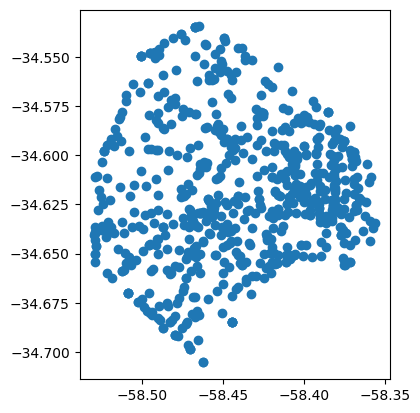

In [18]:
data_c = homicidios_lm.copy()
# Iniciamos CRS
crs={'init':'epsg:4326'}

#Definimos la geometría según nuestro dataset
geometry=[Point(xy) for xy in zip(data_c["pos_x"], data_c["pos_y"])]
#Ua vez que tenemos el sistema de referencia decoordenadas y la geometría; se procede a la carga de los datos
geodata=gpd.GeoDataFrame(data_c,crs=crs, geometry=geometry)

#Se imprime el resultante que luego será introducido en un mapa
geodata.plot()

In [19]:
censo_r = pd.read_csv('../datasets/raw/informacion-censal-por-radio-2010.csv')

In [20]:
censo_r.head(5)

,WKT,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,V_COLECTIV,T_HOGAR,H_CON_NBI,H_SIN_NBI
0,MULTIPOLYGON (((-58.372489764082 -34.591546570...,1,1_1_1,1,1,1,336,212,124,82,80,2,65,19,46
1,MULTIPOLYGON (((-58.3865223305709 -34.60399309...,2,1_12_1,1,12,1,341,184,157,365,361,4,116,25,91
2,MULTIPOLYGON (((-58.3793832787935 -34.60483817...,3,1_12_10,1,12,10,296,162,134,629,627,2,101,1,100
3,MULTIPOLYGON (((-58.3679211414675 -34.60517426...,4,1_12_11,1,12,11,528,294,234,375,370,5,136,7,129
4,MULTIPOLYGON (((-58.3851326494337 -34.60391158...,5,1_12_2,1,12,2,229,101,128,445,445,0,129,16,113


In [21]:
censo_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WKT         3554 non-null   object
 1   ID          3554 non-null   int64 
 2   CO_FRAC_RA  3554 non-null   object
 3   COMUNA      3554 non-null   int64 
 4   FRACCION    3554 non-null   int64 
 5   RADIO       3554 non-null   int64 
 6   TOTAL_POB   3554 non-null   int64 
 7   T_VARON     3554 non-null   int64 
 8   T_MUJER     3554 non-null   int64 
 9   T_VIVIENDA  3554 non-null   int64 
 10  V_PARTICUL  3554 non-null   int64 
 11  V_COLECTIV  3554 non-null   int64 
 12  T_HOGAR     3554 non-null   int64 
 13  H_CON_NBI   3554 non-null   int64 
 14  H_SIN_NBI   3554 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 416.6+ KB


In [22]:
# Lee el archivo CSV
censo_r = pd.read_csv('../datasets/raw/informacion-censal-por-radio-2010.csv')
# Convierte la columna WKT a geometrías
censo_r['geometry'] = censo_r['WKT'].apply(loads)
# Crea un GeoDataFrame
censo_gdf = gpd.GeoDataFrame(censo_r, geometry='geometry')


In [23]:
# Agrupar por la columna 'COMUNA' y sumar las columnas específicas
pol_comuna = censo_r.groupby('COMUNA')[['TOTAL_POB', 'T_VARON', 'T_MUJER', 'T_VIVIENDA', 'V_PARTICUL', 'V_COLECTIV', 'T_HOGAR', 'H_CON_NBI', 'H_SIN_NBI']].sum()

# Mostrar el resultado
print(pol_comuna)


        TOTAL_POB  T_VARON  T_MUJER  T_VIVIENDA  V_PARTICUL  V_COLECTIV  \
COMUNA                                                                    
1          205991    98160   107831      131396      130949         447   
2          157827    67979    89848      108122      107989         133   
3          187537    85601   101936      101436      101216         220   
4          218245   103166   115079       83033       82986          47   
5          179005    80806    98199       92903       92767         136   
6          176076    78870    97206       93481       93394          87   
7          220591   102481   118110       89688       89571         117   
8          187237    89545    97692       55427       55404          23   
9          161797    76207    85590       63414       63343          71   
10         166022    76972    89050       71664       71579          85   
11         189832    88469   101363       84734       84656          78   
12         200116    9252

Text(157.3143480453908, 0.5, 'Latitud')

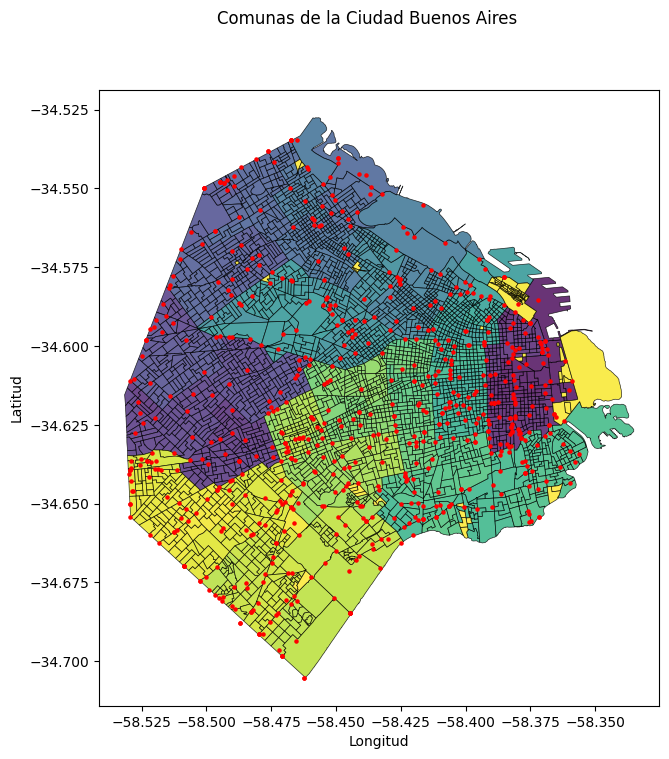

In [24]:


# 	WKT	ID	CO_FRAC_RA	COMUNA	FRACCION	RADIO	TOTAL_POB	T_VARON	T_MUJER	T_VIVIENDA	V_PARTICUL	V_COLECTIV	T_HOGAR	H_CON_NBI	H_SIN_NBI
# 0	MULTIPOLYGON (((-58.372489764082 -34.591546570...	1	1_1_1	1	1	1	336	212	124	82	80	2	65	19	46
# 1	MULTIPOLYGON (((-58.3865223305709 -34.60399309...	2	1_12_1	1	12	1	341	184	157	365	361	4	116	25	91
# 2	MULTIPOLYGON (((-58.3793832787935 -34.60483817...	3	1_12_10	1	12	10	296	162	134	629	627	2	101	1	100
# 3	MULTIPOLYGON (((-58.3679211414675 -34.60517426...	4	1_12_11	1	12	11	528	294	234	375	370	5	136	7	129
# 4	MULTIPOLYGON (((-58.3851326494337 -34.60391158...	5	1_12_2	1	12	2	229	101	128	445	445	0	129	16	113

#Se realiza sobre el mapa de CABA la presentación de los puntos de referencia a los siniestros viales

#Crea ejes y figuras
fig, ax = plt.subplots(figsize=(10,8))

#Dibujar el Shapefile
censo_gdf.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=0.8,linewidth=0.5,cmap="viridis")

#Dibujar los datos geoespaciales
geodata.plot(ax=ax, color='red', markersize=5)

#Agregar título y etiquetas de ejes
fig.suptitle('Comunas de la Ciudad Buenos Aires', fontsize=12)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize='medium')

## Expotar Datos ETL

In [25]:
homicidios_lm.to_csv('../datasets/processed/homicidios_lm.csv')

In [26]:
victima_h_lm.to_csv('../datasets/processed/victima_h_lm.csv')

In [27]:
comunas_h_l.to_csv('../datasets/processed/comunas_h_l.csv')

In [28]:
censo_r_l.to_csv('../datasets/processed/censo_r_l.csv')

In [29]:
#https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos-6
#https://data.buenosaires.gob.ar/dataset/informacion-censal-por-radio

In [30]:
censo_r_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wkt         3554 non-null   object
 1   id          3554 non-null   int64 
 2   co_frac_ra  3554 non-null   object
 3   comuna      3554 non-null   int64 
 4   fraccion    3554 non-null   int64 
 5   radio       3554 non-null   int64 
 6   total_pob   3554 non-null   int64 
 7   t_varon     3554 non-null   int64 
 8   t_mujer     3554 non-null   int64 
 9   t_vivienda  3554 non-null   int64 
 10  v_particul  3554 non-null   int64 
 11  v_colectiv  3554 non-null   int64 
 12  t_hogar     3554 non-null   int64 
 13  h_con_nbi   3554 non-null   int64 
 14  h_sin_nbi   3554 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 416.6+ KB


In [31]:
victima_h_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   rol                  717 non-null    object        
 2   victima              717 non-null    object        
 3   sexo                 717 non-null    object        
 4   edad                 717 non-null    object        
 5   fecha_fallecimiento  717 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 33.7+ KB


In [32]:
comunas_h_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         15 non-null     int64  
 1   objeto     15 non-null     object 
 2   comunas    15 non-null     int64  
 3   barrios    15 non-null     object 
 4   perimetro  15 non-null     float64
 5   area       15 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 848.0+ bytes


In [33]:
victima_h_lm.describe()

,fecha_fallecimiento
count,717
mean,2018-09-10 21:11:17.824267776
min,2016-01-01 00:00:00
25%,2017-04-01 00:00:00
50%,2018-07-07 00:00:00
75%,2019-12-18 00:00:00
max,2022-01-03 00:00:00
